In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Read Data

In [ ]:
dir = ''

In [ ]:
try:
    with open(dir + '/ctg-studies.json', 'r') as f:
        trials = json.load(f)

except FileNotFoundError:
    print(f"Error: File not found.")
except json.JSONDecodeError:
    print(f"Error: Invalid JSON format.")
except Exception as e:
    print(f"An unexpected error occured: {e}")

print('Trials Count:', len(trials))

Trials Count: 111597


# Flatten

In [ ]:
def flatten_json(nested_json, flat_json=None, prefix=''):
    ''' Flatten JSON to appropriate level, accounting for preservation keys '''

    # Preserve in original form, do not flatten
    preserve_list = [
    'protocolSection_conditionsModule_conditions',
    'protocolSection_conditionsModule_keywords',
    'protocolSection_armsInterventionsModule_armGroups',
    'protocolSection_armsInterventionsModule_interventions',
    'protocolSection_outcomesModule_primaryOutcomes',
    'protocolSection_outcomesModule_secondaryOutcomes',
    'protocolSection_outcomesModule_otherOutcomes',
    'resultsSection_adverseEventsModule_eventGroups',
    'resultsSection_adverseEventsModule_seriousEvents',
    'resultsSection_adverseEventsModule_otherEvents'
    ]

    if flat_json is None:
        flat_json = {}

    if isinstance(nested_json, dict):
        for k, v in nested_json.items():
            new_prefix = f"{prefix}{k}_" if prefix else f"{k}_"
            if new_prefix[:-1] in preserve_list and (isinstance(v, dict) or isinstance(v, list)):
                flat_json[new_prefix[:-1]] = v
            else:
                flatten_json(v, flat_json, new_prefix)
    elif isinstance(nested_json, list):
        for i, item in enumerate(nested_json):
            new_prefix = f"{prefix}{i}_"
            flatten_json(item, flat_json, new_prefix)
    else:
        flat_json[prefix[:-1]] = nested_json

    return flat_json

In [ ]:
# Flatten trials to appropriate level
flattened_trials = []
for trial in trials:
    flattened_data = flatten_json(trial)
    flattened_trials.append(flattened_data)

# Accumulate Text
Accumulate relevant text fields

- Titles removed since it is least descriptive relative to the rest of the available text
- We consider secondary outcomes to add excessive tokens with little value in relation to the primary outcome. May consider adding it back with sliding window implementation

In [ ]:
# Text fields to include
'''text_fields = [
    'protocolSection_identificationModule_officialTitle',
    'protocolSection_descriptionModule_briefSummary',
    'protocolSection_descriptionModule_detailedDescription',
    'protocolSection_conditionsModule_conditions',
    'protocolSection_armsInterventionsModule_armGroups',
    'protocolSection_armsInterventionsModule_interventions',
    'protocolSection_outcomesModule_primaryOutcomes',
    'protocolSection_outcomesModule_secondaryOutcomes',
    'protocolSection_eligibilityModule_eligibilityCriteria',
    'protocolSection_eligibilityModule_sex',
    'protocolSection_eligibilityModule_minimumAge',
    'protocolSection_eligibilityModule_maximumAge'
]'''

def printList(item,is_first_list):
  s = ''
  if isinstance(item, dict):
    for k, v in item.items():
      s += str(k.capitalize()) + ': ' + printList(v,False) + '\n'
  if isinstance(item, list):
    for i in range(len(item)):
      if is_first_list:
        s += str(i+1) + ". " + printList(item[i],False)
      elif i == len(item)-1:
        s += printList(item[i],False)
      else:
        s += printList(item[i],False) + ', '
  if isinstance(item,str):
    s += item
  return s

def clean_criteria(text):
  text = text.replace('\n\n', '\n')
  # return text

  # Find the last occurrence of '\n' before 'Exclusion Criteria'
  exclusion_index = text.find("Exclusion Criteria")
  if exclusion_index == -1:
      return text  # "Exclusion Criteria" not found

  last_newline_index = text.rfind("\n", 0, exclusion_index)
  if last_newline_index == -1:
      return text  # No newline found before "Exclusion Criteria"

  return text[:last_newline_index] + "\n\n" + text[last_newline_index + 1:]



def accumulate_text_input(trial):
  ''' Accuumulate relevant text fields into single feature '''
  s = ''
  for key, value in trial.items():
      if key in [# 'protocolSection_identificationModule_officialTitle',
                'protocolSection_descriptionModule_briefSummary',
                'protocolSection_descriptionModule_detailedDescription']:
        s += value + '\n'

      if key == 'protocolSection_conditionsModule_conditions':
        s+= '\nConditions: ' + printList(value,False) + '\n'

      if key == 'protocolSection_armsInterventionsModule_armGroups':
        s += '\nTrial Arms: ' + '\n' + printList(value,True) + '\n'
      if key == 'protocolSection_armsInterventionsModule_interventions':
        s += 'Trial Interventions: ' + '\n' + printList(value,True) + '\n'

      if key == 'protocolSection_outcomesModule_primaryOutcomes':
        s += 'Primary Outcomes: ' + '\n' + printList(value,True) + '\n'
      # if key == 'protocolSection_outcomesModule_secondaryOutcomes':
      #   s += 'Secondary Outcomes: ' + '\n' + printList(value,True) + '\n'

      if key == 'protocolSection_eligibilityModule_eligibilityCriteria':
        s += clean_criteria(value) + '\n\n'   # Remove excess spacing
      if key == 'protocolSection_eligibilityModule_sex':
        s += 'Sex: ' + value + '\n'
      if key == 'protocolSection_eligibilityModule_minimumAge':
        s += 'Minimum Age: ' + value + '\n'
      if key == 'protocolSection_eligibilityModule_maximumAge':
        s += 'Maxmium Age: ' + value + '\n'

  return s

# Test single
# print(accumulate_text_input(flattened_trials[0]))

## Alternate Sectioning Method
Instead of accumulating text in one field, create a section for Intro, Outcomes, and Criteria. This can be useful for model Method 4

In [ ]:
def accumulate_text_intro(trial):
  s = ''
  for key, value in trial.items():
      if key in [# 'protocolSection_identificationModule_officialTitle',
                'protocolSection_descriptionModule_briefSummary',
                'protocolSection_descriptionModule_detailedDescription']:
        s += value + '\n'

      if key == 'protocolSection_conditionsModule_conditions':
        s+= '\nConditions: ' + printList(value,False) + '\n'

      if key == 'protocolSection_armsInterventionsModule_armGroups':
        s += '\nTrial Arms: ' + '\n' + printList(value,True) + '\n'
      if key == 'protocolSection_armsInterventionsModule_interventions':
        s += 'Trial Interventions: ' + '\n' + printList(value,True) + '\n'

  return s

def accumulate_text_outcomes(trial):
  s = ''
  for key, value in trial.items():
      if key == 'protocolSection_outcomesModule_primaryOutcomes':
        s += 'Primary Outcomes: ' + '\n' + printList(value,True) + '\n'
      if key == 'protocolSection_outcomesModule_secondaryOutcomes':
        s += 'Secondary Outcomes: ' + '\n' + printList(value,True) + '\n'

  return s

def accumulate_text_criteria(trial):
  s = ''
  for key, value in trial.items():
      if key == 'protocolSection_eligibilityModule_eligibilityCriteria':
        s += clean_criteria(value) + '\n\n'   # Remove excess spacing
      if key == 'protocolSection_eligibilityModule_sex':
        s += 'Sex: ' + value + '\n'
      if key == 'protocolSection_eligibilityModule_minimumAge':
        s += 'Minimum Age: ' + value + '\n'
      if key == 'protocolSection_eligibilityModule_maximumAge':
        s += 'Maxmium Age: ' + value + '\n'

  return s

## Apply

In [ ]:
# Apply text accumulation to all trials
for trial in flattened_trials:
  trial['acc_text'] = accumulate_text_input(trial)

In [ ]:
for trial in flattened_trials:
  trial['text_intro'] = accumulate_text_intro(trial)
  trial['text_outcomes'] = accumulate_text_outcomes(trial)
  trial['text_criteria'] = accumulate_text_criteria(trial)

In [ ]:
print(flattened_trials[5]['acc_text'], end='\n=================================\n')
print(flattened_trials[5]['text_intro'], end='\n=================================\n')
print(flattened_trials[5]['text_outcomes'], end='\n=================================\n')
print(flattened_trials[5]['text_criteria'], end='\n=================================\n')

kinesio taping would reduce pain, improve gait performance, and enhance the functional capacity of turf toe patients undergoing physical therapy
Health practitioners have recently become interested in using kinesiology taping in clinical practice as an alternative to traditional taping and bracing procedures for treating a variety of diseases, including sprain of metatarsophalangeal joint of the big toe. Patients with turf toe can benefit from kinesiology tape because it offers therapeutic support and stability while preserving a normal range of motion.

Conditions: Turf Toe, Metatarsophalangeal (Joint) Sprain

Trial Arms: 
1. Label: exercise group
Type: EXPERIMENTAL
Description: 60-minutes exercise program, three times a week on alternate days for 12 successive weeks.
Interventionnames: Other: Traditional physical therapy program
2. Label: placebo kinesiology taping plus exercise group
Type: EXPERIMENTAL
Description: Kinesiology taping was used, however the strain was zero. Before eac

# Outcomes
1. Premature Termination (Status is terminated)
2. Adverse Event Rate

The indicator for termination status is already present in the data

There are very few but present cases where the results indicator indicates True, when no results are provided. Change these to False.

In [ ]:
# Check and correct hasResults indicator
for trials in flattened_trials:
  if trials['hasResults'] == True:
    # If key does not exist, set to False
    if 'resultsSection_adverseEventsModule_eventGroups' not in trials:
      print(trials['protocolSection_identificationModule_nctId'])
      trials['hasResults'] = False

NCT03608072


In [ ]:
def count_adverse_events(trial):
  sae_count = 0
  other_ae_count = 0

  try:
      for group in trial['resultsSection_adverseEventsModule_eventGroups']:
          sae_count += group['seriousNumAffected']
          other_ae_count += group['otherNumAffected']
      return sae_count, other_ae_count
  except KeyError:
      return None, None


def breakdown_adverse_events(events):
  ''' Count events by organ system affected '''
  serious_event_counts = {}
  other_event_counts = {}
  # breakdown serious ae
  try:
    for event in trial['resultsSection_adverseEventsModule_seriousEvents']:
      organ_system = event['organSystem']
      total_affected = sum(stat['numAffected'] for stat in event['stats'])
      serious_event_counts[organ_system] = serious_event_counts.get(organ_system, 0) + total_affected
  except KeyError:
    serious_event_counts = None
  # breakdown other ae
  try:
    for event in trial['resultsSection_adverseEventsModule_otherEvents']:
      organ_system = event['organSystem']
      total_affected = sum(stat['numAffected'] for stat in event['stats'])
      other_event_counts[organ_system] = other_event_counts.get(organ_system, 0) + total_affected
  except KeyError:
    other_event_counts = None

  return serious_event_counts, other_event_counts

In [ ]:
for trial in flattened_trials:
  trial['sae_count'], trial['other_ae_count'] = count_adverse_events(trial)
  trial['sae_events'], trial['other_ae_events'] = breakdown_adverse_events(trial)

"Serious" adverse events (AEs) are those resulting in death, criticality, or long-term impairment. "Other" AEs are considered less dire and are weighed at 1/3 as much as "Serious".

In [ ]:
def calculate_ae_score(trial, other_ae_weight = 0.33):
  ''' Calculate an output risk score based on weighted adverse event count ratio '''
  if trial['hasResults'] == True:
    return (trial['sae_count'] + (trial['other_ae_count'] * other_ae_weight)) / trial['protocolSection_designModule_enrollmentInfo_count']
  else:
    return None

In [ ]:
for i, trial in enumerate(flattened_trials):
  trial['ae_score'] = calculate_ae_score(trial, 0.33)

# Create Dataframe

In [ ]:
# Create dataframe
df_trials = pd.DataFrame(flattened_trials)
display(df_trials)
print(df_trials.info())

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_overallStatus,protocolSection_statusModule_startDateStruct_date,protocolSection_oversightModule_oversightHasDmc,protocolSection_oversightModule_isFdaRegulatedDrug,protocolSection_oversightModule_isFdaRegulatedDevice,protocolSection_descriptionModule_briefSummary,protocolSection_conditionsModule_conditions,...,other_ae_events,ae_score,protocolSection_descriptionModule_detailedDescription,protocolSection_outcomesModule_otherOutcomes,protocolSection_statusModule_whyStopped,resultsSection_adverseEventsModule_eventGroups,resultsSection_adverseEventsModule_seriousEvents,resultsSection_adverseEventsModule_otherEvents,protocolSection_eligibilityModule_maximumAge,protocolSection_oversightModule_isUnapprovedDevice
0,NCT05294731,Treatment of Chinese Participants With B-Cell ...,"A Phase 1/2, Open-Label, Dose-Escalation and E...",RECRUITING,2022-05-06,False,False,False,This study aims to explore the recommended pha...,"[B-cell Malignancy, Non-Hodgkin Lymphoma, Mant...",...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCT04228731,Inpatient vs Outpatient Total Knee Replacement,Cost and Patient Satisfaction Associated With ...,COMPLETED,2020-10-22,NaN,False,False,This is a prospective cohort study comparing s...,"[Osteoarthritis, Knee]",...,None,NaN,Osteoarthritis (OA) is a leading cause of disa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT06398431,Validating Wireless Gait Sensor for Elderly Fa...,A Study on Validation of Gait Analysis Wireles...,COMPLETED,2023-12-01,False,False,False,The walking status of elderly patients over 65...,[Elderly Person],...,None,NaN,"Currently, in the case of general clinical war...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT03810131,Study Protocol for a Feasibility Study of a No...,Study Protocol for a Feasibility Study of a No...,COMPLETED,2022-07-01,False,False,False,Here we propose a protocol for assessing the f...,[A Bite of ACT' (BOA) Acceptance and Commitmen...,...,None,NaN,Introduction: Recent studies reveal a high pre...,"[{'measure': 'Heart rate variability (HRV)', '...",NaN,NaN,NaN,NaN,NaN,NaN
4,NCT04688931,A Phase 3 Study of UGN-102 for Low-Grade Inter...,"A Randomized, Controlled, Open-Label Study of ...",TERMINATED,2021-02-19,NaN,True,False,"This global, randomized, controlled, open-labe...","[Bladder Cancer, Urothelial Carcinoma, Urothel...",...,"{'Renal and urinary disorders': 161, 'Gastroin...",0.259291,Eligible patients were randomized in a 1:1 rat...,NaN,Alternate approach pursued,"[{'deathsNumAffected': 0, 'deathsNumAtRisk': 1...",[{'organSystem': 'Infections and infestations'...,[{'organSystem': 'Renal and urinary disorders'...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111592,NCT05318287,Walk With Me for Perinatal Grief,Walk With Me (WWM) for Perinatal Grief,COMPLETED,2021-02-01,False,False,False,This research will contribute to therapeutic t...,"[Grief, Traumatic Stress, Usability]",...,None,0.000000,The investigators will develop grief processin...,NaN,NaN,"[{'deathsNumAffected': 0, 'deathsNumAtRisk': 5...",NaN,NaN,NaN,NaN
111593,NCT03725787,Pressure Ulcer Incidence Cat. II+ on a Static ...,Pressure Ulcer Incidence Cat. II+ on the CuroC...,COMPLETED,2018-03-04,False,False,False,Pressure Ulcers are a serious and common probl...,"[Pressure Ulcer, Pressure Injury, Pressure Sor...",...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111594,NCT05149287,PROPER Trial of Pain and Inflammation After Kn...,Early Reduction of Post-opeRative Pain and Inf...,TERMINATED,2021-12-28,NaN,True,False,The purpose of this study is to determine if c...,"[Meniscus Tear, Meniscus Lesion, Cartilage Inj...",...,None,0.000000,Arthroscopic surgery for cartilage and meniscu...,NaN,Funding stopped,"[{'deathsNumAffected': 0, 'deathsNumAtRisk': 3...",NaN,NaN,55 Years,NaN
111595,NCT04861987,A Study of the Safety and PK of PCS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111597 entries, 0 to 111596
Data columns (total 42 columns):
 #   Column                                                     Non-Null Count   Dtype  
---  ------                                                     --------------   -----  
 0   protocolSection_identificationModule_nctId                 111597 non-null  object 
 1   protocolSection_identificationModule_briefTitle            111597 non-null  object 
 2   protocolSection_identificationModule_officialTitle         111597 non-null  object 
 3   protocolSection_statusModule_overallStatus                 111597 non-null  object 
 4   protocolSection_statusModule_startDateStruct_date          111597 non-null  object 
 5   protocolSection_oversightModule_oversightHasDmc            93989 non-null   object 
 6   protocolSection_oversightModule_isFdaRegulatedDrug         111556 non-null  object 
 7   protocolSection_oversightModule_isFdaRegulatedDevice       111556 non-null  object 

# More Preprocess

## Handle date type and columns

In [ ]:
# Set date type
# Convert to datetime with errors='coerce'
df_trials['start_date'] = pd.to_datetime(df_trials['protocolSection_statusModule_startDateStruct_date'], errors='coerce')

# Find rows where start_date is NaT (YYYY-MM dates)
nat_rows = df_trials['start_date'].isna()

# Create a copy of the original string column
temp_date_strings = df_trials['protocolSection_statusModule_startDateStruct_date'].copy()

# Append '-01' to NaT rows
temp_date_strings[nat_rows] = temp_date_strings[nat_rows] + '-01'

# Convert the modified strings to datetime
df_trials['start_date'] = df_trials['start_date'].fillna(pd.to_datetime(temp_date_strings, errors='coerce'))

In [ ]:
# Keep relevant columns
keep_col = [
    'start_date',
    'protocolSection_identificationModule_nctId',
    'protocolSection_statusModule_overallStatus',
    'protocolSection_oversightModule_oversightHasDmc',
    'protocolSection_oversightModule_isFdaRegulatedDrug',
    'protocolSection_oversightModule_isFdaRegulatedDevice',
    'protocolSection_oversightModule_isUnapprovedDevice',
    'protocolSection_designModule_phases_0',
    'protocolSection_designModule_phases_1',
    'protocolSection_designModule_designInfo_allocation',
    'protocolSection_designModule_designInfo_interventionModel',
    'protocolSection_designModule_designInfo_primaryPurpose',
    'hasResults',
    'acc_text',
    'text_intro',
    'text_outcomes',
    'text_criteria',
    'sae_count',
    'other_ae_count',
    'sae_events',
    'other_ae_events',
    'ae_score',
    'protocolSection_statusModule_whyStopped',
    'resultsSection_adverseEventsModule_eventGroups',
    'resultsSection_adverseEventsModule_seriousEvents',
    'resultsSection_adverseEventsModule_otherEvents',
]

# Keep columns in list, ignore if not in list
keep_col = [col for col in keep_col if col in df_trials.columns]
df_trials = df_trials[keep_col]

In [ ]:
# Rename columns
df_trials.rename(columns={
    'protocolSection_identificationModule_nctId': 'id',
    'protocolSection_statusModule_overallStatus': 'status',
    'protocolSection_oversightModule_oversightHasDmc': 'dmc_oversight',
    'protocolSection_oversightModule_isFdaRegulatedDrug': 'fda_drug',
    'protocolSection_oversightModule_isFdaRegulatedDevice': 'fda_device',
    'protocolSection_designModule_phases_0': 'phase',
    'protocolSection_designModule_designInfo_allocation': 'allocation',
    'protocolSection_designModule_designInfo_interventionModel': 'intervention_model',
    'protocolSection_designModule_designInfo_primaryPurpose': 'primary_purpose',
    'protocolSection_designModule_enrollmentInfo_count' : 'enroll_count',
    # 'hasResults': ,
    # 'acc_text' : ,
    # 'sae_count': ,
    # 'other_ae_count': ,
    # 'sae_events': ,
    # 'other_ae_events': ,
    # 'ae_score': ,
    'protocolSection_statusModule_whyStopped': 'why_stopped',
    'protocolSection_oversightModule_isUnapprovedDevice': 'unapproved_device'
}, inplace=True)

# Reorder columns
df_trials = df_trials[['id',
           'start_date',
           'status',
           'why_stopped',
           'hasResults',
           'phase',
           'allocation',
           'intervention_model',
           'primary_purpose',
           'acc_text',
           'text_intro',
           'text_outcomes',
           'text_criteria',
           'dmc_oversight',
           'fda_drug',
           'fda_device',
           'unapproved_device',
           'ae_score',
           'sae_events',
           'other_ae_events',
]]


<ipython-input-23-67d200ca4be0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trials.rename(columns={


In [ ]:
display(df_trials.columns)
df_trials.head()

Index(['id', 'start_date', 'status', 'why_stopped', 'hasResults', 'phase',
       'allocation', 'intervention_model', 'primary_purpose', 'acc_text',
       'text_intro', 'text_outcomes', 'text_criteria', 'dmc_oversight',
       'fda_drug', 'fda_device', 'unapproved_device', 'ae_score', 'sae_events',
       'other_ae_events'],
      dtype='object')

,id,start_date,status,why_stopped,hasResults,phase,allocation,intervention_model,primary_purpose,acc_text,text_intro,text_outcomes,text_criteria,dmc_oversight,fda_drug,fda_device,unapproved_device,ae_score,sae_events,other_ae_events
0,NCT05294731,2022-05-06,RECRUITING,NaN,False,PHASE1,RANDOMIZED,PARALLEL,TREATMENT,This study aims to explore the recommended pha...,This study aims to explore the recommended pha...,Primary Outcomes: \n1. Measure: Phase 1: Numbe...,Key Inclusion Criteria\n1. Provision of signed...,False,False,False,NaN,NaN,None,None
1,NCT04228731,2020-10-22,COMPLETED,NaN,False,NA,NON_RANDOMIZED,PARALLEL,HEALTH_SERVICES_RESEARCH,This is a prospective cohort study comparing s...,This is a prospective cohort study comparing s...,Primary Outcomes: \n1. Measure: Indirect and d...,Inclusion Criteria:\n* Osteoarthritis of the k...,NaN,False,False,NaN,NaN,None,None
2,NCT06398431,2023-12-01,COMPLETED,NaN,False,NA,NA,SINGLE_GROUP,DEVICE_FEASIBILITY,The walking status of elderly patients over 65...,The walking status of elderly patients over 65...,Primary Outcomes: \n1. Measure: Falls Risk Ass...,Inclusion Criteria:\n1. a person over the age ...,False,False,False,NaN,NaN,None,None
3,NCT03810131,2022-07-01,COMPLETED,NaN,False,NA,RANDOMIZED,CROSSOVER,TREATMENT,Here we propose a protocol for assessing the f...,Here we propose a protocol for assessing the f...,Primary Outcomes: \n1. Measure: Acceptance Che...,Inclusion Criteria:\n- 1. Participants will be...,False,False,False,NaN,NaN,None,None
4,NCT04688931,2021-02-19,TERMINATED,Alternate approach pursued,True,PHASE3,RANDOMIZED,PARALLEL,TREATMENT,"This global, randomized, controlled, open-labe...","This global, randomized, controlled, open-labe...",Primary Outcomes: \n1. Measure: Disease-free S...,Inclusion Criteria:\n1. Capable of giving sign...,NaN,True,False,NaN,0.259291,"{'Infections and infestations': 10, 'Renal and...","{'Renal and urinary disorders': 161, 'Gastroin..."


## Outcomes

### Termination

In [ ]:
# Check terminated vs completed rate
df_trials_finished = df_trials[df_trials['status'].isin(['COMPLETED', 'TERMINATED'])].copy()
df_trials_finished['status'].value_counts(normalize=True)

,proportion
status,
COMPLETED,0.897676
TERMINATED,0.102324


### AE Risk Score

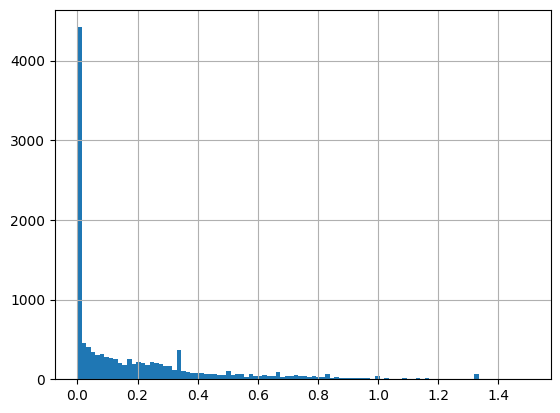

,ae_score
count,12188.000000
mean,0.216807
std,2.521514
min,0.000000
25%,0.000000
50%,0.082500
75%,0.291705
max,277.005926


In [ ]:
# graph aescore
df_trials['ae_score'].hist(bins=100, range=(0, 1.5))
plt.show()

df_trials['ae_score'].describe()

## Categorical/Bool Data Validation

In [ ]:
print('Size:', (len(df_trials)))
display(df_trials['phase'].value_counts())
display(df_trials['allocation'].value_counts())
display(df_trials['intervention_model'].value_counts())
display(df_trials['primary_purpose'].value_counts())
display(df_trials['dmc_oversight'].value_counts())
display(df_trials['fda_drug'].value_counts())
display(df_trials['fda_device'].value_counts())
display(df_trials['unapproved_device'].value_counts())

Size: 111597


,count
phase,
NA,67146
PHASE1,16024
PHASE2,14017
PHASE3,6812
PHASE4,5720
EARLY_PHASE1,1836


,count
allocation,
RANDOMIZED,73670
NA,26808
NON_RANDOMIZED,11070


,count
intervention_model,
PARALLEL,67004
SINGLE_GROUP,28034
CROSSOVER,9125
SEQUENTIAL,6163
FACTORIAL,1271


,count
primary_purpose,
TREATMENT,66147
PREVENTION,11323
OTHER,9621
SUPPORTIVE_CARE,7800
BASIC_SCIENCE,6493
DIAGNOSTIC,4906
HEALTH_SERVICES_RESEARCH,3497
SCREENING,1257
DEVICE_FEASIBILITY,553


,count
dmc_oversight,
False,60544
True,33445


,count
fda_drug,
False,89517
True,22039


,count
fda_device,
False,104526
True,7030


,count
unapproved_device,
True,1853


## Add Oxford Stringency

In [ ]:
# Load Oxford Stringency simplified data
df_stringency = pd.read_csv(dir + '/OxCGRT_simplified_v1.csv')

# Filter for only USA national aggregate. Future case may consider local regions.
# Sort by date
df_stringency = df_stringency[(df_stringency.CountryCode == 'USA') & (df_stringency.Jurisdiction == 'NAT_TOTAL')].sort_values(by='Date')
df_stringency = df_stringency[['Date', 'StringencyIndex_Average']]

# Manage date type
df_stringency['Date'] = pd.to_datetime(df_stringency['Date'], format='%Y%m%d')

<ipython-input-28-1fae348eb6e0>:2: DtypeWarning: Columns (2,3,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stringency = pd.read_csv(dir + '/OxCGRT_simplified_v1.csv')


The World Health Organization determined the pandemic over in May 2023, with national emergency ending in US on 5/11. Experiment with linear decreasing stringency until 5/11.

5/11 is 131 days into 2023.
28.71 on last day on 2022-12-31.
0.219 decrease per day until 0 on 5/11

In [ ]:
date = pd.to_datetime('2022-12-31')
stringency_index = 28.71

while stringency_index > 0:
  # Make daily update
  date = date + pd.Timedelta(days=1)
  stringency_index = round(max(0, stringency_index - 0.219), 3)
  # Create record
  record = {'Date': date, 'StringencyIndex_Average': stringency_index}
  # Add row
  df_stringency = pd.concat([df_stringency, pd.DataFrame([record])], ignore_index=True)

df_stringency.sort_values(by='Date', ascending=True)

,Date,StringencyIndex_Average
0,2020-01-01,0.000
1,2020-01-02,0.000
2,2020-01-03,0.000
3,2020-01-04,0.000
4,2020-01-05,0.000
...,...,...
1223,2023-05-08,0.678
1224,2023-05-09,0.459
1225,2023-05-10,0.240
1226,2023-05-11,0.021


Join the index, dates outside of the range default to 0 for stringency index

In [ ]:
df_trials = df_trials.merge(df_stringency[['Date', 'StringencyIndex_Average']], left_on='start_date', right_on='Date', how='left')

# Fill NaN with 0
df_trials['StringencyIndex_Average'] = df_trials['StringencyIndex_Average'].fillna(0)
# Drop the Date column from right
df_trials = df_trials.drop('Date', axis=1)

# Rename
df_trials = df_trials.rename(columns={'StringencyIndex_Average': 'stringency_index'})

In [ ]:
# #graph date and stringency index
# df_sorted = df_trials.sort_values('start_date')

# plt.figure(figsize=(5, 3))
# plt.plot(df_sorted['start_date'], df_sorted['stringency_index'])

# # Customize the plot
# plt.title('Stringency Index Over Time')
# plt.xlabel('Start Date')
# plt.ylabel('Stringency Index')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Show the plot
# plt.show()

# Data Check

In [ ]:
display(df_trials.info())
display(df_trials.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111597 entries, 0 to 111596
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  111597 non-null  object        
 1   start_date          111597 non-null  datetime64[ns]
 2   status              111597 non-null  object        
 3   why_stopped         7006 non-null    object        
 4   hasResults          111597 non-null  bool          
 5   phase               111555 non-null  object        
 6   allocation          111548 non-null  object        
 7   intervention_model  111597 non-null  object        
 8   primary_purpose     111597 non-null  object        
 9   acc_text            111597 non-null  object        
 10  text_intro          111597 non-null  object        
 11  text_outcomes       111597 non-null  object        
 12  text_criteria       111597 non-null  object        
 13  dmc_oversight       93989 non

None

,id,start_date,status,why_stopped,hasResults,phase,allocation,intervention_model,primary_purpose,acc_text,...,text_outcomes,text_criteria,dmc_oversight,fda_drug,fda_device,unapproved_device,ae_score,sae_events,other_ae_events,stringency_index
0,NCT05294731,2022-05-06,RECRUITING,NaN,False,PHASE1,RANDOMIZED,PARALLEL,TREATMENT,This study aims to explore the recommended pha...,...,Primary Outcomes: \n1. Measure: Phase 1: Numbe...,Key Inclusion Criteria\n1. Provision of signed...,False,False,False,NaN,NaN,None,None,27.91
1,NCT04228731,2020-10-22,COMPLETED,NaN,False,NA,NON_RANDOMIZED,PARALLEL,HEALTH_SERVICES_RESEARCH,This is a prospective cohort study comparing s...,...,Primary Outcomes: \n1. Measure: Indirect and d...,Inclusion Criteria:\n* Osteoarthritis of the k...,NaN,False,False,NaN,NaN,None,None,66.20
2,NCT06398431,2023-12-01,COMPLETED,NaN,False,NA,NA,SINGLE_GROUP,DEVICE_FEASIBILITY,The walking status of elderly patients over 65...,...,Primary Outcomes: \n1. Measure: Falls Risk Ass...,Inclusion Criteria:\n1. a person over the age ...,False,False,False,NaN,NaN,None,None,0.00
3,NCT03810131,2022-07-01,COMPLETED,NaN,False,NA,RANDOMIZED,CROSSOVER,TREATMENT,Here we propose a protocol for assessing the f...,...,Primary Outcomes: \n1. Measure: Acceptance Che...,Inclusion Criteria:\n- 1. Participants will be...,False,False,False,NaN,NaN,None,None,31.98
4,NCT04688931,2021-02-19,TERMINATED,Alternate approach pursued,True,PHASE3,RANDOMIZED,PARALLEL,TREATMENT,"This global, randomized, controlled, open-labe...",...,Primary Outcomes: \n1. Measure: Disease-free S...,Inclusion Criteria:\n1. Capable of giving sign...,NaN,True,False,NaN,0.259291,"{'Infections and infestations': 10, 'Renal and...","{'Renal and urinary disorders': 161, 'Gastroin...",68.06


- Pandas correctly set the hasResults field to bool. Other boolean fields were not recognized by Pandas because of missing values. These will be encoded as 3 categories.
- Start date should be a date type.
- Risk score and stringency index should be floats.

# Split

Split between finished and recruiting trials. Further split finished trials into having and not having results.

In [ ]:
df_trials_recruiting = df_trials[df_trials['status'] == 'RECRUITING'].copy()
df_trials_finished = df_trials[df_trials['status'].isin(['COMPLETED', 'TERMINATED'])].copy()

print(f'RECRUITING trials: {len(df_trials_recruiting)}')
print(f'FINISHED trials: {len(df_trials_finished)}')
print()
print(f"FINISHED-Completed trials: {len(df_trials_finished[df_trials_finished.status == 'COMPLETED'])}")
print(f"FINISHED-Terminated trials: {len(df_trials_finished[df_trials_finished.status == 'TERMINATED'])}")

RECRUITING trials: 43109
FINISHED trials: 68488

FINISHED-Completed trials: 61480
FINISHED-Terminated trials: 7008


Finished Trials w/ vs w/o results

In [ ]:
df_trials_finished_y_res = df_trials_finished[df_trials_finished.hasResults == True].copy()
df_trials_finished_n_res = df_trials_finished[df_trials_finished.hasResults == False].copy()

print(f"Has results: {len(df_trials_finished_y_res)}")
print(f"No results: {len(df_trials_finished_n_res)}")

Has results: 12187
No results: 56301


Stratification split. Do indepdenent random data splits within Having Results and Not Having Results.

In [ ]:
def data_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
  ''' Split data into train, validation, and test sets '''

  # Ensure the ratios add up to 1
  assert train_ratio + val_ratio + test_ratio == 1

  # Shuffle the DataFrame
  shuffled_df = df.sample(frac=1, random_state=1522)

  # Calculate split points
  train_end = int(len(shuffled_df) * train_ratio)
  val_end = train_end + int(len(shuffled_df) * val_ratio)

  # Split the DataFrame
  train_df = shuffled_df[:train_end]
  val_df = shuffled_df[train_end:val_end]
  test_df = shuffled_df[val_end:]

  return train_df, val_df, test_df

In [ ]:
# W results
df_y_res_train, df_y_res_val, df_y_res_test = data_split(df_trials_finished_y_res, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)
# W/o results
df_n_res_train, df_n_res_val, df_n_res_test = data_split(df_trials_finished_n_res, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Check counts
print('With Results:')
print(f"Train: {len(df_y_res_train)}")
print(f"Val: {len(df_y_res_val)}")
print(f"Test: {len(df_y_res_test)}")
print()
print('Without Results:')
print(f"Train: {len(df_n_res_train)}")
print(f"Val: {len(df_n_res_val)}")
print(f"Test: {len(df_n_res_test)}")

With Results:
Train: 8530
Val: 1828
Test: 1829

Without Results:
Train: 39410
Val: 8445
Test: 8446


In [ ]:
# Combine
df_trials_train = pd.concat([df_y_res_train, df_n_res_train])
df_trials_val = pd.concat([df_y_res_val, df_n_res_val])
df_trials_test  = pd.concat([df_y_res_test, df_n_res_test])

# Shuffle
df_trials_train = df_trials_train.sample(frac=1, random_state=38531)
df_trials_val = df_trials_val.sample(frac=1, random_state=38531)
df_trials_test = df_trials_test.sample(frac=1, random_state=38531)

# Check counts
print(f"Train: {len(df_trials_train)}")
print(f"Val: {len(df_trials_val)}")
print(f"Test: {len(df_trials_test)}")

Train: 47940
Val: 10273
Test: 10275


## Check Split Randomization

In [ ]:
# Numerical Variables
numerical_cols = ['stringency_index']

train_desc = df_trials_train[numerical_cols].describe().add_prefix('Train_')
val_desc = df_trials_val[numerical_cols].describe().add_prefix('Val_')
test_desc = df_trials_test[numerical_cols].describe().add_prefix('Test_')

combined_desc = pd.concat([train_desc, val_desc, test_desc], axis=1)
display(combined_desc)

,Train_stringency_index,Val_stringency_index,Test_stringency_index
count,47940.000000,10273.000000,10275.000000
mean,25.844016,25.821871,26.163170
std,28.255650,28.248480,28.244576
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,12.723000,13.818000,17.541000
75%,52.480000,52.480000,52.480000
max,75.460000,75.460000,75.460000


In [ ]:
# Categorical Variables
categorical_cols = ['phase',
                    'allocation',
                    'intervention_model',
                    'primary_purpose',
                    'dmc_oversight',
                    'fda_drug',
                    'fda_device',
                    'unapproved_device']

splits = {'Train': df_trials_train, 'Validation': df_trials_val, 'Test': df_trials_test}

for col in categorical_cols:
    category_counts = {}
    all_unique_values = pd.Series()

    all_unique_values = []  # Initialize as an empty list
    for name, df in splits.items():
        counts = df[col].value_counts()
        category_counts[name] = counts
        all_unique_values.extend(counts.index.tolist())  # Extend the list with unique values

    # Convert the list to a unique set and then to a Pandas Index
    all_unique_values = pd.Index(list(set(all_unique_values)), name=col)

    # Create a DataFrame to display the counts
    distribution_df = pd.DataFrame(index=all_unique_values)  # Use the unique index

    for name, counts in category_counts.items():
        distribution_df[name] = counts.fillna(0).astype(int)

    display(distribution_df.sort_index()) # Sort by unique value for better readability

,Train,Validation,Test
phase,,,
EARLY_PHASE1,669,141,125
NA,29947,6490,6394
PHASE1,7138,1505,1560
PHASE2,4991,1037,1053
PHASE3,2690,555,597
PHASE4,2477,540,538


,Train,Validation,Test
allocation,,,
NA,10454,2196,2207
NON_RANDOMIZED,4436,927,958
RANDOMIZED,33019,7144,7098


,Train,Validation,Test
intervention_model,,,
CROSSOVER,4861,1057,1041
FACTORIAL,575,106,125
PARALLEL,28995,6298,6237
SEQUENTIAL,2482,513,529
SINGLE_GROUP,11027,2299,2343


,Train,Validation,Test
primary_purpose,,,
BASIC_SCIENCE,3171,652,668
DEVICE_FEASIBILITY,267,63,65
DIAGNOSTIC,1935,423,416
HEALTH_SERVICES_RESEARCH,1651,379,333
OTHER,4848,1046,1065
PREVENTION,5340,1116,1130
SCREENING,583,114,117
SUPPORTIVE_CARE,3717,788,810
TREATMENT,26428,5692,5671


,Train,Validation,Test
dmc_oversight,,,
False,27666,6015,5930
True,12716,2651,2757


,Train,Validation,Test
fda_drug,,,
False,38525,8276,8265
True,9387,1992,2002


,Train,Validation,Test
fda_device,,,
False,44956,9655,9712
True,2956,613,555


,Train,Validation,Test
unapproved_device,,,
True,807,169,155


# Export

In [ ]:
# Save
df_trials_train.to_csv(dir + '/trials_train.csv', index=False)
df_trials_val.to_csv(dir + '/trials_val.csv', index=False)
df_trials_test.to_csv(dir + '/trials_test.csv', index=False)